### Example finding flares via HEK and then getting GOES/XRS15 data

Note: several ways of doing and plotting this. The following works but there be more "optimal" ways.

Other resources: [Sunpy doc on goes flare list from HEK](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/querying_the_GOES_event_list.html#sphx-glr-generated-gallery-acquiring-data-querying-the-goes-event-list-py) and [Sunpy doc on getting/plotting XRS](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/goes_xrs_example.html#sphx-glr-generated-gallery-acquiring-data-goes-xrs-example-py)

**Note** that SWPC events are found as described in [https://ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/documentation/readme_solar-features_solar-flares.pdf](https://ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/documentation/readme_solar-features_solar-flares.pdf), i.e. in 1 min data looking for 

* Start: 4 consecutive 1-min bins > B1 level, all are increasing, and last is 1.4x first bin
* Peak: max flux
* End: 1/2 of (max+start) flux

The result flare list is then processed by [ssw latest events](https://www.lmsal.com/solarsoft/latest_events/) to add more info (such as flare locations).

---

* 22-10-21   IGH
* 23-10-21   Fixed axvline needing a datetime, not a string
* 25-11-21   Added in info about difference in fluxes from data and catalogue
* 10-11-22   Changed to return SSW Latest Events instead of SWPC and also do GOES16 version
* 12-11-22   Added in flare list info
---

In [1]:
#  Import in the usual stuff
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.time import Time
from astropy.time import TimeDelta
from sunpy.time import parse_time

#  Here just assuming it save to your sunpy/data dir but can of course change
outdir='/Users/iain/sunpy/data/'

In [2]:
# Let's look for all the X-class flares in 2017
trange=a.Time("2017-01-01 00:00","2018-01-01 00:00")
# This version only returns the SWPC ones, so same as a.hek.FRM.Name == "SWPC"
# res = Fido.search(trange,a.hek.EventType("FL"),a.hek.FL.GOESCls > "X1.0",a.hek.OBS.Observatory == "GOES")
# This is ssw latest events, which are the SWPC but with more info, like position
res = Fido.search(trange,a.hek.EventType("FL"),a.hek.FL.GOESCls > "X1.0",a.hek.FRM.Name == "SSW Latest Events")

hekres = res["hek"]

In [3]:
#  Four X-class flares in 2017 and lot's of info in the HEK about them
hekres

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs [8]
str131,str1,str120,str5,str20,str12,object,str29,object,str130,object,str57,str41,Time,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str70,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str18,str1,object,object,str17,object,str9,str3,str1,int64,str1,int64,str5,str110,str1,str1,str1,object,str99,str20,object,object,object,str1,str1,str1,int64,object,str19,str7,float64,float64,str3,object,str19,str15,object,str20,str1,object,str1,str1,str2,str66,str17,int64,int64,object,int64,str1,str1,object,str5,int64,float64,object,int64,str1,str1,int64,str4,str1,str1,str3,int64,str1,str19,Time,object,int64,object,int64,str3,object,str5,str1,str1,object,float64,float64,Time,int64,str1,str4,str12,str1,object,object,str1,str1,object,str1,str19,object,str30,str1,str1,object
http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_client/data/ssw_service_170906_094839_25912/www/ssw_cutout_193_context_thumb.gif,0,"POLYGON((16.679092 -103.964646,16.679092 -103.964646,16.679092 -103.964646,16.679092 -103.964646,16.679092 -103.964646))",false,POINT(115.929197 -8),UTC-HGS-TOPO,None,POINT(501.171102 -233.008824),None,http://sdowww.lmsal.com/sdomedia/ssw/media/ssw/ssw_client/data/ssw_service_170906_094839_25912/www/ssw_cutout_193_context_full.gif,None,"AIA20170906_085700_0094.fits,AIA20170906_091102_0094.fits",POINT(0.580893736757299 245.06493180857),2017-09-06 08:57:00.000,,FL,None,None,9.4e-07,http://sohowww.nascom.nasa.gov/solarsoft/packages/gevloc/idl/ssw_flare_locator.pro,,,false,,true,None,None,,,None,,01030000000100000005000000483140A289DF7840ECA9D557570375C0483140A289DF78400987DEE2E13960C0D84B5304F8E282400987DEE2E13960C0D84B5304F8E28240ECA9D557570375C0483140A289DF7840ECA9D557570375C0,"POLYGON((84.929197 1,84.929197 1,84.929197 1,84.929197 1,84.929197 1))",None,,EUV,,,SOL2017-09-06T08:57:00L115C098,None,9,,,,Samuel L. Freeland,,None,None,SSW Latest Events,None,SolarSoft,SDO,,-7,,-9,LMSAL,"POLYGON((0.110667 189.114321,0.110667 189.114321,0.110667 189.114321,0.110667 189.114321,0.110667 189.114321))",,,,None,http://sdowww.lmsal.com/sdomedia/ssw/media/

In [4]:
# Reduce the table down to just the info we want
shrt_res = hekres["event_starttime", "event_peaktime",
                        "event_endtime", "fl_goescls", "hpc_x", "hpc_y", "ar_noaanum"]
                        # More stuff that could be useful, Heliographic lat lon, and where from
                        # "event_endtime", "fl_goescls", "hpc_x", "hpc_y", "ar_noaanum", "hgc_x", "hgc_y", "frm_name"]
shrt_res

event_starttime,event_peaktime,event_endtime,fl_goescls,hpc_x,hpc_y,ar_noaanum
Time,Time,Time,str4,float64,float64,int64
2017-09-06 08:57:00.000,2017-09-06 09:10:00.000,2017-09-06 09:17:00.000,X2.2,501.171102,-233.008824,2673
2017-09-06 11:53:00.000,2017-09-06 12:02:00.000,2017-09-06 12:10:00.000,X9.3,527.43879,-246.825594,2673
2017-09-07 14:20:00.000,2017-09-07 14:36:00.000,2017-09-07 14:55:00.000,X1.3,702.47112,-211.601262,2673
2017-09-10 15:35:00.000,2017-09-10 16:06:00.000,2017-09-10 16:31:00.000,X8.2,942.69654,-135.662304,2673


In [5]:
# Now get the XRS data for the second flare (first missing in G15 data)
# Want data for +/-10 mins of flare, using astopy time to do this (easier sunpy way?)

gtstart=Time(shrt_res[1]["event_starttime"],scale='utc')-TimeDelta(10*60,format='sec')
gtend=Time(shrt_res[1]["event_endtime"],scale='utc')+TimeDelta(10*60,format='sec')
print(gtstart)
print(gtend)

# Search and get the XRS data
tflrange=a.Time(gtstart.iso,gtend.iso)
rg15 = Fido.search(tflrange, a.Instrument("XRS"), a.goes.SatelliteNumber(15))
print(rg15)
fg15 = Fido.fetch(rg15,path=outdir,overwrite=False)

2017-09-06 11:43:00.000
2017-09-06 12:20:00.000
Results from 1 Provider:

1 Results from the XRSClient:
Source: <13: https://umbra.nascom.nasa.gov/goes/fits 
13, 14, 15: https://satdat.ngdc.noaa.gov/sem/goes/data/science/ 
16, 17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2017-09-06 00:00:00.000 2017-09-06 23:59:59.999        XRS ...   GOES     NOAA




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [6]:
# Load data file in, truncate to desired time range, extract out time index and data 
fg15=glob.glob(outdir+'*g15*20170906*.nc')
g15 = ts.TimeSeries(fg15, concatenate=True)

tg15=g15.truncate(tflrange.start.iso,tflrange.end.iso)

tg_tims=tg15.index
tg_x05=tg15.quantity("xrsa").value
tg_x18=tg15.quantity("xrsb").value


In [7]:
# What is the peak flux in the GOES data now as data has been reprocessed to remove scaling but catalogue values not changed?
# i.e. https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/GOES_13-15_XRS_Science-Quality_Data_Readme.pdf
max18=max(tg_x18)
new_fl_goescls="X{0:.1f}".format(1e4*max18)
print("New peak flux ",new_fl_goescls)
print("Catalogue peak flux ",shrt_res[1]["fl_goescls"])
rat=float(shrt_res[1]["fl_goescls"][1:])/(1e4*max18)
print(f'Ratio old/new (should be ~0.7 as GOES15): {rat:.2f}')

New peak flux  X13.5
Catalogue peak flux  X9.3
Ratio old/new (should be ~0.7 as GOES15): 0.69


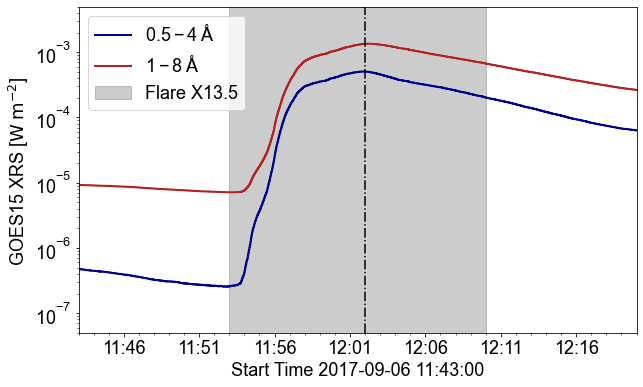

In [8]:
# And then plot it all
tfl=a.Time(shrt_res[1]["event_starttime"],shrt_res[1]["event_endtime"])

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,tg_x05,drawstyle='steps-post',marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')
plt.plot(tg_tims,tg_x18,drawstyle='steps-post',marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')

ax.set_ylabel("GOES15 XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Start Time "+tflrange.start.iso[:-4])
ax.set_yscale("log")
ax.set_ylim([5e-8,5e-3])
ax.set_xlim([tflrange.start.datetime,tflrange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)

# Using sunpy parse_time here to produce datetime version from string
ax.axvline(parse_time(shrt_res[1]["event_peaktime"]).datetime,color='black',ls='-.')
# tfl is a sunpy attrs time range so easy to get datetime out
# ax.axvspan(tfl.start.datetime,tfl.end.datetime,color='black',alpha=0.2, label='Flare '+shrt_res[1]["fl_goescls"])
# Label with the new GOES class
ax.axvspan(tfl.start.datetime,tfl.end.datetime,color='black',alpha=0.2, label='Flare '+new_fl_goescls)

plt.legend()
# plt.tight_layout()
# plt.savefig('xflare.pdf')
plt.show()

---

### Now try if for a more recent GOES16 flare

In [9]:
# What do we get for a more recent time range when no GOES15 - basically the same but the GOES Class should correctly match the new unscaled data?

trange2=a.Time("2022-01-01 00:00","2022-11-01 00:00")
res2 = Fido.search(trange2,a.hek.EventType("FL"),a.hek.FL.GOESCls > "X1.0",a.hek.FRM.Name == "SSW Latest Events")
hekres2 = res2["hek"]
shrt_res2 = hekres2["event_starttime", "event_peaktime",
                        "event_endtime", "fl_goescls", "ar_noaanum","hpc_x","hpc_y","hgc_x","hgc_y","frm_name"]
shrt_res2

event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,hpc_x,hpc_y,hgc_x,hgc_y,frm_name
Time,Time,Time,str4,int64,float64,float64,float64,int64,str17
2022-03-30 17:21:00.000,2022-03-30 17:37:00.000,2022-03-30 17:46:00.000,X1.3,2975,483.659832,308.217828,84.904748,13,SSW Latest Events
2022-04-17 03:17:00.000,2022-04-17 03:34:00.000,2022-04-17 03:51:00.000,X1.1,2994,-934.086,200.871276,96.07453,12,SSW Latest Events
2022-04-20 03:41:00.000,2022-04-20 03:57:00.000,2022-04-20 04:04:00.000,X2.2,2992,789.92574,-526.891776,-129.7647,-34,SSW Latest Events
2022-04-30 13:37:00.000,2022-04-30 13:47:00.000,2022-04-30 13:52:00.000,X1.1,2994,914.60724,264.064164,94.6502877,16,SSW Latest Events
2022-05-03 13:09:00.000,2022-05-03 13:25:00.000,2022-05-03 13:31:00.000,X1.1,0,-823.57602,-472.683828,-120.74303,-30,SSW Latest Events
2022-05-10 13:50:00.000,2022-05-10 13:55:00.000,2022-05-10 13:59:00.000,X1.5,3006,58.1840028,-415.31331,-121.66148,-29,SSW Latest Events


In [10]:
gtstart2=Time(shrt_res2[0]["event_starttime"],scale='utc')-TimeDelta(10*60,format='sec')
gtend2=Time(shrt_res2[0]["event_endtime"],scale='utc')+TimeDelta(10*60,format='sec')
print(gtstart2)
print(gtend2)

# Search and get the XRS data
tflrange2=a.Time(gtstart2.iso,gtend2.iso)
rg16 = Fido.search(tflrange2, a.Instrument("XRS"), a.goes.SatelliteNumber(16))
print(rg16)
fg16 = Fido.fetch(rg16,path=outdir,overwrite=False)

g16 = ts.TimeSeries(fg16, concatenate=True)
tg16=g16.truncate(tflrange2.start.iso,tflrange2.end.iso)

tg2_tims=tg16.index
tg2_x05=tg16.quantity("xrsa").value
tg2_x18=tg16.quantity("xrsb").value


2022-03-30 17:11:00.000
2022-03-30 17:56:00.000
Results from 1 Provider:

1 Results from the XRSClient:
Source: <13: https://umbra.nascom.nasa.gov/goes/fits 
13, 14, 15: https://satdat.ngdc.noaa.gov/sem/goes/data/science/ 
16, 17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2022-03-30 00:00:00.000 2022-03-30 23:59:59.999        XRS ...   GOES     NOAA




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [11]:
# This GOES Class in the flare list should match the actual peak in the data
max218=max(tg2_x18)
new2_fl_goescls="X{0:.1f}".format(1e4*max218)
print("New peak flux ",new2_fl_goescls)
print("Catalogue peak flux ",shrt_res2[0]["fl_goescls"])
rat2=float(shrt_res2[0]["fl_goescls"][1:])/(1e4*max218)
print(f'Ratio old/new (should be ~1 as GOES16): {rat2:.2f}')

New peak flux  X1.4
Catalogue peak flux  X1.3
Ratio old/new (should be ~1 as GOES16): 0.94


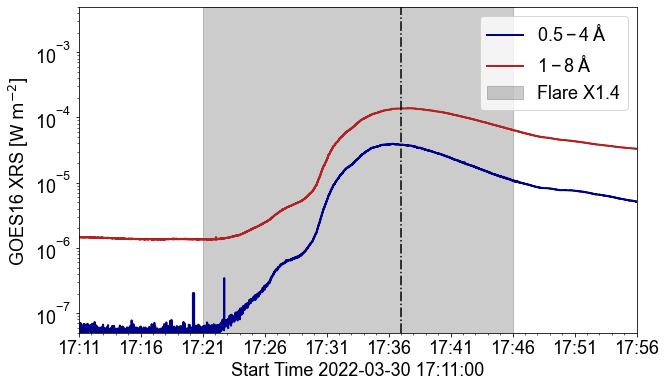

In [12]:
# And then plot it all
tfl2=a.Time(shrt_res2[0]["event_starttime"],shrt_res2[0]["event_endtime"])

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg2_tims,tg2_x05,drawstyle='steps-post',marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')
plt.plot(tg2_tims,tg2_x18,drawstyle='steps-post',marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')

ax.set_ylabel("GOES16 XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Start Time "+tflrange2.start.iso[:-4])
ax.set_yscale("log")
ax.set_ylim([5e-8,5e-3])
ax.set_xlim([tflrange2.start.datetime,tflrange2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)

ax.axvline(parse_time(shrt_res2[0]["event_peaktime"]).datetime,color='black',ls='-.')
ax.axvspan(tfl2.start.datetime,tfl2.end.datetime,color='black',alpha=0.2, label='Flare '+new2_fl_goescls)

plt.legend()
plt.show()